In [1]:
from glob import glob

# How many images do we have?

GLOB = '/kaggle/input/car-camera-photos/images/images/*'

print(len(list(glob(pathname=GLOB))))

22241


This is a lot of images; we have too many for an interactive view, but maybe we can do some EDA using a static plot. Let's try.

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 512

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 132MB/s]


Getting embeddings for 22K images takes a while, so sit tight.

In [3]:
import base64
import pandas as pd
from arrow import now
from glob import glob
from io import BytesIO
from os.path import basename
from PIL import Image

DATA = '/kaggle/input/car-camera-photos/images/images'
THUMBNAIL_SIZE = (96, 96)


def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


def get_picture_from_glob(arg: str) -> pd.Series:
    time_get = now()
    result = pd.Series(data=[basename(arg), embed(model=model, filename=arg), ], index=['name', 'value', ])
    return result

time_start = now()

df = pd.DataFrame(data=[get_picture_from_glob(arg=value) for value in list(glob(DATA + '/*.jpg'))])
print('done in {}'.format(now() - time_start))

done in 0:23:47.618937


Now let's load up the label data and merge.

In [4]:
df = df.merge(right=pd.read_csv(filepath_or_buffer='/kaggle/input/car-camera-photos/labels_train.csv'), left_on='name', right_on='frame')
df = df.drop_duplicates(ignore_index=True, subset=['name'])

We have our data and our labels; what do our classes look like?

In [5]:
df.head()

,name,value,frame,xmin,xmax,ymin,ymax,class_id
0,1478020894712588023.jpg,"[2.0725107, 1.9327061, 1.172914, 0.82692915, 0...",1478020894712588023.jpg,229,254,137,154,1
1,1479502069714972898.jpg,"[0.9942462, 1.631726, 0.582592, 1.0997323, 1.8...",1479502069714972898.jpg,50,166,117,195,1
2,1479500482587459937.jpg,"[1.1718231, 4.1336675, 1.6602513, 0.42962426, ...",1479500482587459937.jpg,110,123,139,150,1
3,1478732638089007825.jpg,"[2.5519118, 4.7600904, 2.8344846, 0.5478969, 0...",1478732638089007825.jpg,101,202,4,151,2
4,1479498594981336285.jpg,"[0.8184468, 2.7105885, 2.545974, 0.7424777, 1....",1479498594981336285.jpg,118,132,141,151,1


In [6]:
df['class_id'].value_counts(normalize=True).to_dict()

{1: 0.8477222222222223,
 2: 0.058833333333333335,
 3: 0.050555555555555555,
 5: 0.03327777777777778,
 4: 0.009611111111111112}

Our data is mostly class 1, so our plot is going to be dominated by one class.

In [7]:
import arrow
from umap import UMAP

time_start = arrow.now()
umap = UMAP(random_state=2024, verbose=True, n_jobs=1, low_memory=False, n_epochs=201, init='random')
df[['x', 'y']] = umap.fit_transform(X=df['value'].apply(func=pd.Series))
print('done with UMAP in {}'.format(arrow.now() - time_start))

2024-08-11 10:11:17.424362: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-11 10:11:17.424523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-11 10:11:17.642861: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


UMAP(init='random', low_memory=False, n_epochs=201, n_jobs=1, random_state=2024, verbose=True)
Sun Aug 11 10:11:33 2024 Construct fuzzy simplicial set
Sun Aug 11 10:11:33 2024 Finding Nearest Neighbors
Sun Aug 11 10:11:33 2024 Building RP forest with 12 trees
Sun Aug 11 10:11:40 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	 6  /  14
	Stopping threshold met -- exiting after 6 iterations
Sun Aug 11 10:12:03 2024 Finished Nearest Neighbor Search
Sun Aug 11 10:12:07 2024 Construct embedding


Epochs completed:   0%|            0/201 [00:00]

	completed  0  /  201 epochs
	completed  20  /  201 epochs
	completed  40  /  201 epochs
	completed  60  /  201 epochs
	completed  80  /  201 epochs
	completed  100  /  201 epochs
	completed  120  /  201 epochs
	completed  140  /  201 epochs
	completed  160  /  201 epochs
	completed  180  /  201 epochs
	completed  200  /  201 epochs
Sun Aug 11 10:12:20 2024 Finished embedding
done with UMAP in 0:00:50.040368


<Axes: xlabel='x', ylabel='y'>

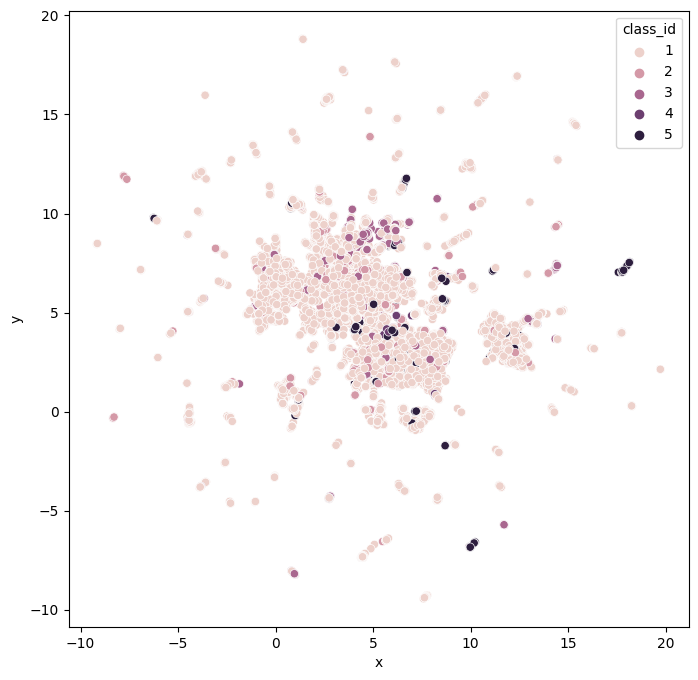

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=df, x='x', y='y', hue='class_id', ax=ax)

Hmmm.

In [9]:
df[['name', 'x', 'y']].nunique()

name    18000
x       17992
y       17995
dtype: int64

In [10]:
df.shape

(18000, 10)

In [11]:
df.head()

,name,value,frame,xmin,xmax,ymin,ymax,class_id,x,y
0,1478020894712588023.jpg,"[2.0725107, 1.9327061, 1.172914, 0.82692915, 0...",1478020894712588023.jpg,229,254,137,154,1,0.818066,1.085484
1,1479502069714972898.jpg,"[0.9942462, 1.631726, 0.582592, 1.0997323, 1.8...",1479502069714972898.jpg,50,166,117,195,1,0.347993,6.793143
2,1479500482587459937.jpg,"[1.1718231, 4.1336675, 1.6602513, 0.42962426, ...",1479500482587459937.jpg,110,123,139,150,1,1.943317,9.362548
3,1478732638089007825.jpg,"[2.5519118, 4.7600904, 2.8344846, 0.5478969, 0...",1478732638089007825.jpg,101,202,4,151,2,9.449958,7.009692
4,1479498594981336285.jpg,"[0.8184468, 2.7105885, 2.545974, 0.7424777, 1....",1479498594981336285.jpg,118,132,141,151,1,4.244702,6.077816
